# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/supervised_classification.ipynb)


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kshitijrajsharma/nickyspatial/master?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fexamples%2Fsupervised_classification.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
# ! pip install nickyspatial

## Summary

In this notebook we will perform following steps
- Load a sample raster image.
- Perform segmentation on the raster.
- Add NDVI feature.
- Define classes and sample collection
- Apply supervised classification using Random Forest Classifier
- Explore additional funtions: Merge_regions, Enclosed_by, Touched_by

In [2]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd

from nickyspatial import (
    plot_layer_interactive_plotly,
    LayerManager,
    SlicSegmentation,
    plot_classification,
    plot_sample,
    plot_layer,
    read_raster,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassifier,
    CNNClassifier,
    Layer ,
    plot_training_history
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "sample.tif")


if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/sample.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [3]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (4, 877, 1164)
Coordinate system: EPSG:32654


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [4]:
manager = LayerManager()

segmenter = SlicSegmentation(scale=20, compactness=0.50)
# segmenter = SlicSegmentation(scale=20, compactness=0.50)

segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 2552
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 2543)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

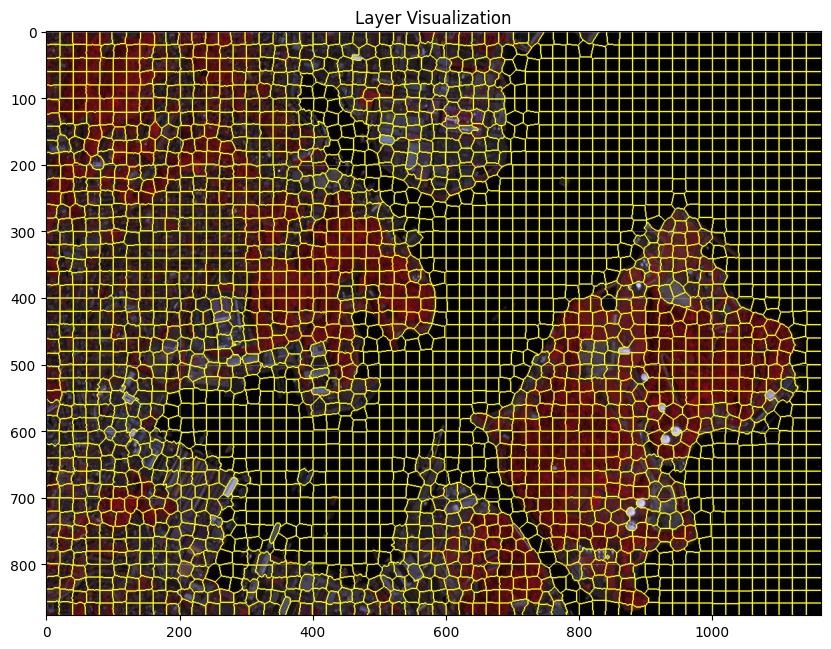

In [5]:
# plt.close("all")
# %matplotlib inline
fig1 = plot_layer(layer=segmentation_layer, image_data=image_data, rgb_bands=(3, 2, 1), show_boundaries=True, figsize=(10,8))
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

## Sample data collection

Using plotly package, interactive map is plotted to collect the segments_id(sample) for supervised classification.

Just Hover the mouse in the map, segment_id will be displayed.



In [6]:
plot_layer_interactive_plotly(segmentation_layer, image_data, rgb_bands=(3,2,1), show_boundaries=True, figsize=(900,600))

In [7]:
# Sample Data for Classification
# This section defines the sample data used for classification. 
# Each class is assigned with a list of segment IDs and a specific color for visualization.

samples={
    "Water": [102,384,659,1142,1662,1710,2113,2182,2481,1024],
    "Builtup": [467,1102,1431,1984,1227,1736,774,1065],
    "Vegetation": [832,1778,2035,1417,1263,242,2049,2397],
}

# samples={
#     'Water': [39, 104, 211, 307],
#     'Builtup': [302, 193,319,197],
#     'Vegetation': [178, 28, 213,379],
# }

classes_color= {
    "Water": "#3437c2",
    "Builtup":"#de1421",
    "Vegetation": "#0f6b2f"
}



## Sample Data Visualization

In this steps, defined sample segment is visualized.

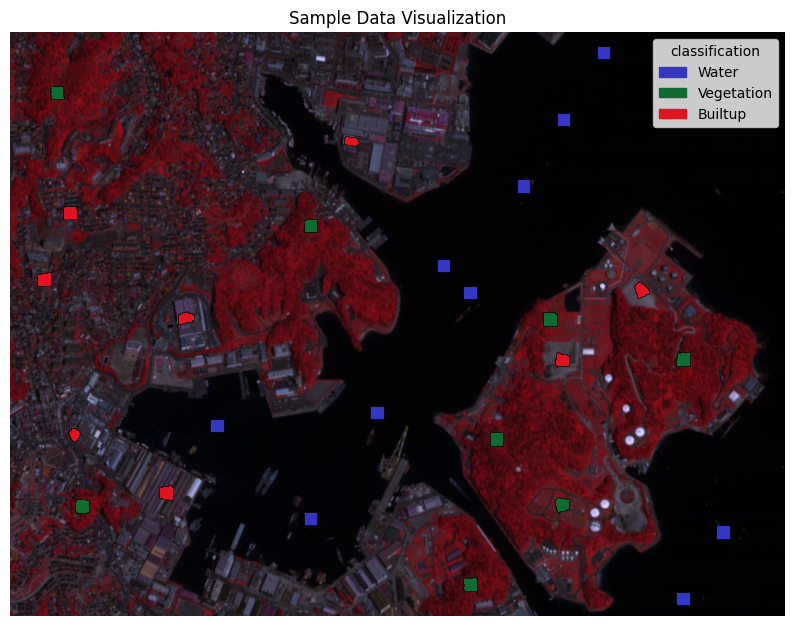

In [8]:
sample_objects = segmentation_layer.objects.copy()
sample_objects["classification"] = None

for class_name in samples.keys():
    sample_objects.loc[sample_objects["segment_id"].isin(samples[class_name]), "classification"] = class_name

# Step 3: Wrap the modified GeoDataFrame back into a Layer
sample_layer = Layer(name="Sample Classification", type="classification")
sample_layer.objects = sample_objects

fig = plot_sample(
    sample_layer,
    image_data=image_data,          
    rgb_bands=(3,2,1),
    transform=transform,          
    class_field="classification",
    class_color=classes_color,
    figsize=(10,8)

)
plt.show()

Extracted 308 training patches of shape (5, 5, 4)
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7027 - loss: 1.0703 - val_accuracy: 0.8140 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8246 - loss: 0.9713 - val_accuracy: 0.8140 - val_loss: 0.8957 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8806 - loss: 0.8701 - val_accuracy: 0.8837 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9292 - loss: 0.7410 - val_accuracy: 0.9767 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.5778 - val_accuracy: 0.9767 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9871 - loss: 0.4460 - val_accuracy: 0.9767 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0

<module 'matplotlib.pyplot' from '/Users/rabinatwayana/Rabina/CDE II/application development/nickyspatial/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

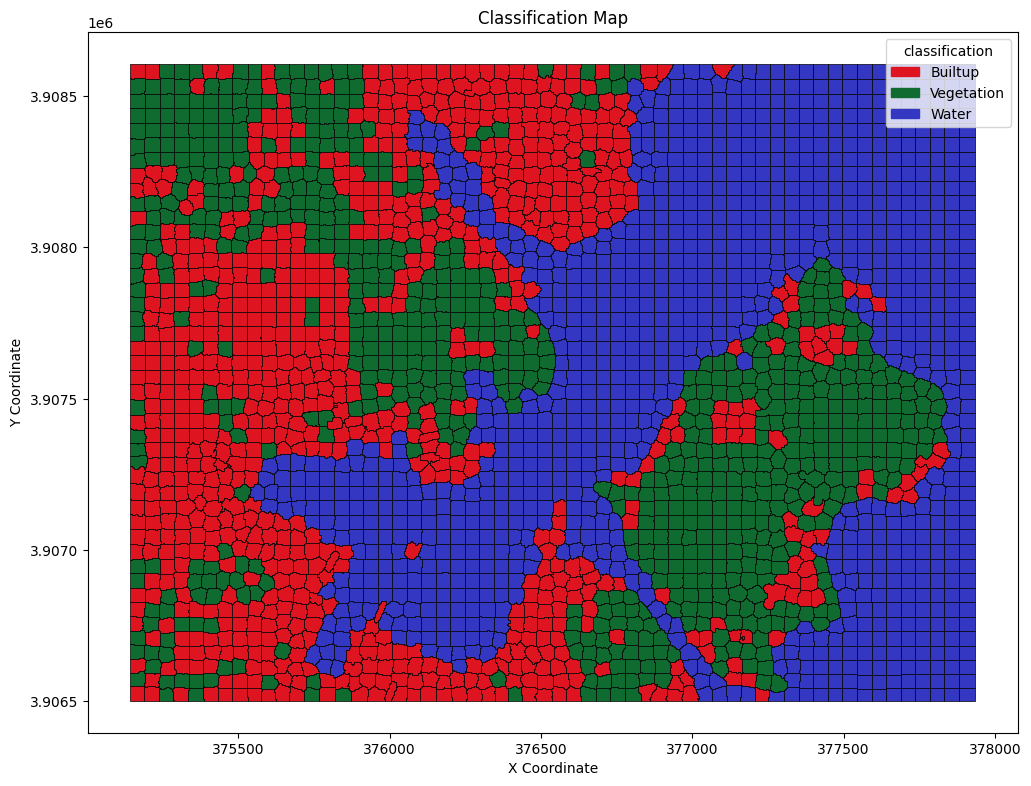

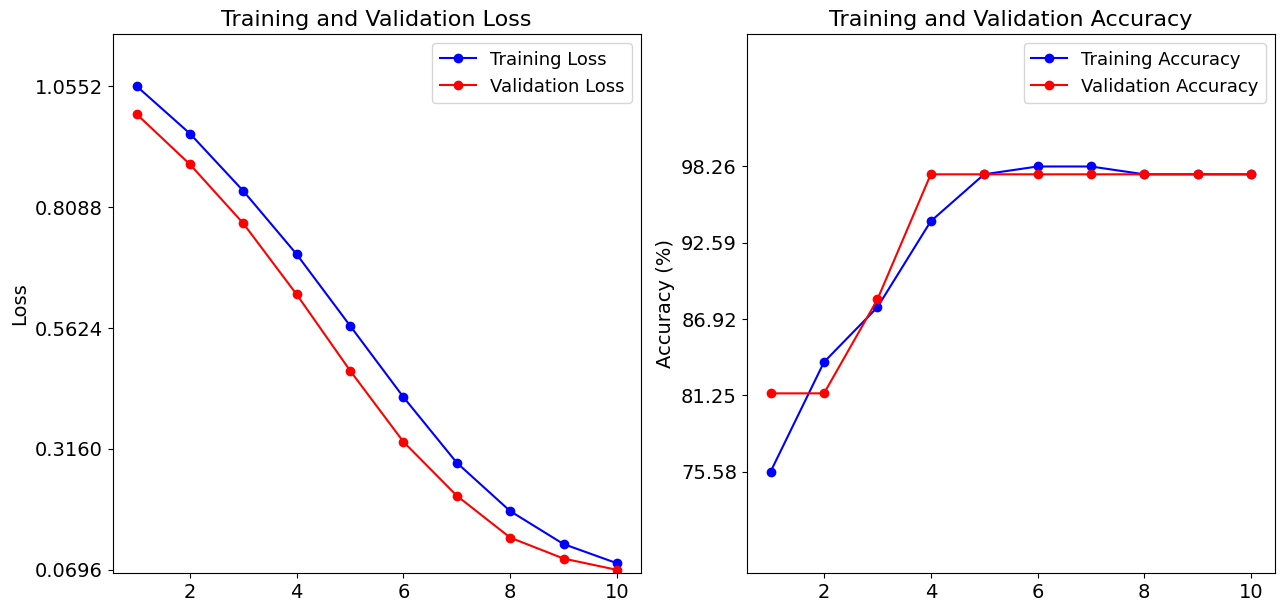

In [ ]:
params={
        "patch_size":(5, 5), 
        "epochs": 60, 
        "batch_size": 32
}

# Define supervised classifier and execute it
CNN_classification=CNNClassifier(name="CN Classification", classifier_params=params)
result_layer, model_history, eval_result=CNN_classification.execute(source_layer=segmentation_layer,samples=samples, image_data=image_data, layer_manager=manager,layer_name="CNN Classification")

fig4 = plot_classification(result_layer, class_field="classification", class_color=classes_color)
plot_training_history(model_history)